# Select patients from FAERS

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd 
import feather 

from utils import Utils
from database import Database
from drug import Drug

u = Utils()
db = Database('Mimir from Munnin')
np.random.seed(u.RANDOM_STATE)

In [2]:
from IPython.display import display
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

def set_style():
    plt.style.use(['seaborn-white', 'seaborn-paper'])
    matplotlib.rc("font", family="Arial")
set_style()

## Find valid patients

In [3]:
# get patients that have sex 
q_patients_w_sex = "SELECT safetyreportid, patient_sex, patient_custom_master_age FROM effect_openfda_19q2.patient WHERE patient_sex='Female' OR patient_sex='Male'"
res_patients_w_sex = db.run_query(q_patients_w_sex)

Connection opened successfully.


In [4]:
# make dataframe 
df_patients = pd.DataFrame(res_patients_w_sex, columns=['PID','Sex','Age'])

In [5]:
# replace 'Male' 'Female' with M, F
df_patients = df_patients.replace('Female','F').replace('Male','M')

# age as int, replace missing with '-1'
df_patients = df_patients.replace('','-1').astype({'Age': 'float'}).astype({'Age': 'int'})

Age Missing:  0.38473168782376316 %


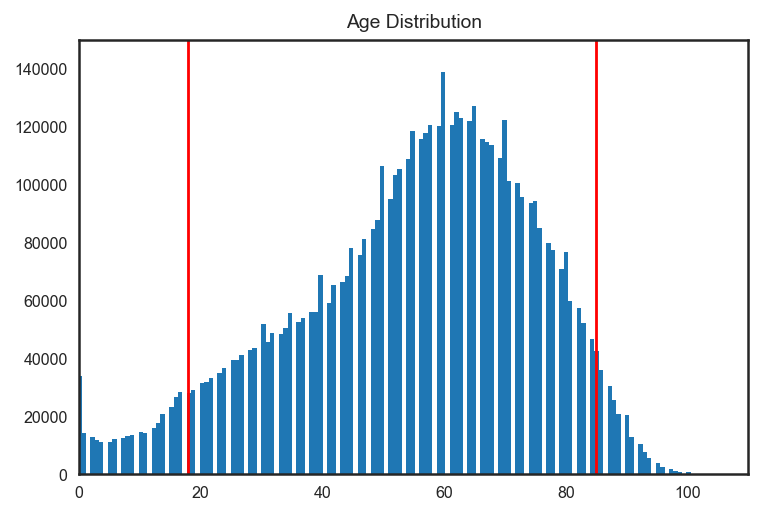

In [6]:
# age missing
age_missing = df_patients.query('Age=="-1"').count()[0]/len(df_patients)
print("Age Missing: ", age_missing, "%")

# age distribution
plt.hist(df_patients.Age, bins=10000)
plt.title('Age Distribution')
x=150000
plt.ylim(0,x)
plt.xlim(0,110)
plt.vlines(18,0,x,'r')
plt.vlines(85,0,x,'r')
plt.show()

In [7]:
# impute missing age with mean 
age_mean = df_patients.query('Age!="-1"').get('Age').mean()
print("Mean Age before imputing: ", age_mean)
df_patients = df_patients.replace(-1,int(age_mean))
print("Mean Age after imputing: ", df_patients.get('Age').mean())

# remove age below 18 and above 85
print("Underage/Overage removed: ", (len(df_patients.query('Age<18'))+len(df_patients.query('Age>85')))/len(df_patients), "%")
df_patients = df_patients.query('Age>=18 and Age<=85')

Mean Age before imputing:  54.70459527612865
Mean Age after imputing:  54.433515146311024
Underage/Overage removed:  0.052491185686737954 %


In [78]:
#db.run_query("DROP TABLE IF EXISTS user_pc2800.patient")
q_create_valid_patients = "CREATE TABLE user_pc2800.patient (PID VARCHAR(255) NOT NULL, PRIMARY KEY (PID), FOREIGN KEY (PID) REFERENCES effect_openfda_19q2.patient(safetyreportid) );"
db.run_query(q_create_valid_patients)
db.close_connection()

Database connection closed.


In [ ]:
win = 100000
for x in range(0, int(len(valid_PID)/win)+1):
    q_insert_valid_patients = "INSERT INTO user_pc2800.patient (PID) VALUES "

    for PID in valid_PID[x*win:x*win+win]: 
        q_insert_valid_patients += "('"+PID+"'), "

    q_insert_valid_patients = "".join(list(q_insert_valid_patients)[:-2])

    res_insert_valid_patients = db.run_query(q_insert_valid_patients)

In [11]:
u.save_df(df_patients, 'df_patients')

In [12]:
valid_PID = df_patients.get('PID').to_numpy()
u.save_np(valid_PID, "valid_PID")

## Load valid patients

In [ ]:
df_patients = u.load_df('df_patients')
valid_PID = u.load_np("valid_PID")

In [ ]:
print("Female patients: ", 100*df_patients.query('Sex=="F"').shape[0]/df_patients.shape[0], "%")